In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
%matplotlib inline

In [2]:
df_train = pd.read_csv('data/sales_train.csv.gz', compression='gzip')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
df_test_ = pd.read_csv('data/test.csv.gz', compression='gzip')
df_test_.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
df_items = pd.read_csv('data/items.csv')
df_item_bigcat = pd.read_csv('data/df_item_bigcat.csv')
df_item_bigcat = df_item_bigcat.merge(df_items)
df_item_bigcat.drop(['item_category_name', 'item_name'], axis=1, inplace=True)
df_item_bigcat = df_item_bigcat.astype(str)
df_item_bigcat.head()

,item_category_id,bigcat,item_id
0,0,PC - Гарнитуры/Наушники,5441
1,0,PC - Гарнитуры/Наушники,16255
2,0,PC - Гарнитуры/Наушники,16256
3,0,PC - Гарнитуры/Наушники,16257
4,1,Access,5606


In [5]:
## Pivot by monht to wide format
df_train_piv = df_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
df_train_piv.head()

date_block_num    0     1    2    3    4    5    6    7    8    9  ...    24  \
shop_id item_id                                                    ...         
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [6]:
df_train_piv.reset_index(inplace=True)
df_train_piv['shop_id']= df_train_piv.shop_id.astype('str')
df_train_piv['item_id']= df_train_piv.item_id.astype('str')

In [7]:
df_train_piv = df_train_piv.merge(df_item_bigcat, how="inner", on="item_id")
df_train_piv.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,bigcat
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,40,Movie
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie


In [8]:
# Encode Categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df_train_piv[['bigcat']] = number.fit_transform(df_train_piv.bigcat)

In [9]:
df_train_piv = df_train_piv[['shop_id', 'item_id', 'bigcat'] + list(range(34))]
df_train_piv.head()

,shop_id,item_id,bigcat,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,7,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,7,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,7,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,7,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X = df_train_piv.iloc[:,  (df_train_piv.columns != 33)].values
y = df_train_piv.iloc[:, df_train_piv.columns == 33].values.ravel()
shopids = df_train_piv['shop_id'].values

In [31]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
train_index, val_index = next(skf.split(X, shopids))
X_train, y_train = X[train_index], y[train_index]
X_val, y_val = X[val_index], y[val_index]

In [41]:
from sklearn.model_selection import train_test_split

# X, y = sklearn.datasets.load_digits(10,True)
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [42]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 100
rf = RandomForestRegressor(warm_start=True, criterion='mse', n_jobs=-1)

train_scores = []
val_scores = []
for i in range(1, n_estimators + 1):
    rf.set_params(n_estimators=i)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    val_pred = rf.predict(X_val)
    train_score = np.sqrt(mean_squared_error(train_pred, y_train))
    val_score = np.sqrt(mean_squared_error(val_pred, y_val))                    
    print(i, train_score, val_score)

1 4.16653880901 2.39364209901
2 2.24889151681 1.61717106098
3 2.80412273737 1.55687955232
4 2.1703644125 1.38487528637
5 2.46191808131 1.26242008961
6 2.06588431007 1.21211729584
7 2.31257119044 1.18098017588
8 2.50267673425 1.15036150428
9 2.64131716296 1.23373197047
10 2.75723165994 1.19685162434
11 2.52079674537 1.23044019972
12 2.33466911775 1.26564939858
13 2.17086714373 1.29107198861
14 2.28931830803 1.28821591153
15 2.15204032198 1.28302299797
16 2.25866871382 1.3252601995
17 2.1419330425 1.32024462346
18 2.04058144449 1.33263970835
19 2.12701902878 1.30795246139
20 2.21054264633 1.31256225401
21 2.12027733506 1.31185954027
22 2.03667272706 1.28637184214
23 2.11220067611 1.26914945987
24 2.03104376011 1.24956559137
25 1.95335744241 1.26173581806
26 2.02518118541 1.2441788287
27 1.95281421741 1.25697737798
28 1.89230750582 1.24421560479
29 1.82985128665 1.23373828096
30 1.77782007066 1.2451857876
31 1.83827657651 1.25723964332
32 1.89806807012 1.25507502132
33 1.84235082015 1.263

In [44]:
df_test = df_test_.copy()
df_test['shop_id']= df_test_.shop_id.astype('str')
df_test['item_id']= df_test_.item_id.astype('str')

df_test = df_test.merge(df_train_piv, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
df_test.head()

,ID,shop_id,item_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
d = dict(zip(df_test.columns[4:],list(np.array(list(df_test.columns[4:])) - 1)))
df_test  = df_test.rename(d, axis = 1)
df_test.head()

,ID,shop_id,item_id,bigcat,-1,0,1,2,3,4,...,23,24,25,26,27,28,29,30,31,32
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
preds = rf.predict(df_test.iloc[:, (df_test.columns != 'ID') & (df_test.columns != -1)].values)

# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

# xgbost

In [21]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
param = {'max_depth':5, 
         'subsample':0.8,
         'colsample_bytree':0.8,
         'min_child_weight':0.5,
         'eta':0.3, 
         'seed':1,
         'eval_metric':'rmse'}


for train_index, val_index in skf.split(X, shopids):
    xgbtrain = xgb.DMatrix(X[train_index], y[train_index])
    xgbval = xgb.DMatrix(X[val_index], y[val_index])
    watchlist  = [(xgbtrain,'train'), (xgbval,'val')]
    bst = xgb.train(param, xgbtrain, num_boost_round = 100,evals=watchlist, early_stopping_rounds=10)

In [118]:
xgbtrainval = xgb.DMatrix(X, y)
bst = xgb.train(param, xgbtrainval, num_boost_round = 12,evals=watchlist)

[0]	train-rmse:1.70036	val-rmse:6.8206
[1]	train-rmse:1.50098	val-rmse:5.82116
[2]	train-rmse:1.37395	val-rmse:4.97068
[3]	train-rmse:1.28153	val-rmse:4.25256
[4]	train-rmse:1.22528	val-rmse:3.65141
[5]	train-rmse:1.19112	val-rmse:3.15089
[6]	train-rmse:1.1687	val-rmse:2.73285
[7]	train-rmse:1.1561	val-rmse:2.38849
[8]	train-rmse:1.14906	val-rmse:2.10515
[9]	train-rmse:1.14378	val-rmse:1.87235
[10]	train-rmse:1.14071	val-rmse:1.68524
[11]	train-rmse:1.13889	val-rmse:1.53646


In [111]:
preds = bst.predict(xgbtrainval)
rmse = np.sqrt(mean_squared_error(preds,df_train_piv.iloc[:, df_train_piv.columns == 33].values))
print(rmse)

1.19635008245


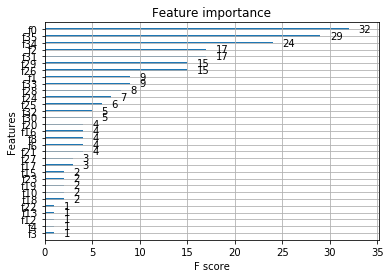

In [112]:
xgb.plot_importance(bst)

In [113]:
df_test = df_test_.copy()
df_test['shop_id']= df_test_.shop_id.astype('str')
df_test['item_id']= df_test_.item_id.astype('str')

df_test = df_test.merge(df_train_piv, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
df_test.head()

,ID,shop_id,item_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
d = dict(zip(df_test.columns[4:],list(np.array(list(df_test.columns[4:])) - 1)))
df_test  = df_test.rename(d, axis = 1)
df_test.head()

,ID,shop_id,item_id,bigcat,-1,0,1,2,3,4,...,23,24,25,26,27,28,29,30,31,32
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
preds = bst.predict(xgb.DMatrix(df_test.iloc[:, (df_test.columns != 'ID') & (df_test.columns != -1)].values))

# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

In [ ]:
kaggle competitions submit -c competitive-data-science-final-project -f submission.csv -m "Message"